In [1]:
# python peripherals
import sys
from pathlib import Path
from typing import Callable
sys.path.append('../../.')

# numpy
import numpy

# torch
import torch

# matplotlib
import matplotlib
import matplotlib.pyplot
import matplotlib.axes

# deep-signature
from deep_signature.core.base import SeedableObject
from deep_signature.manifolds.planar_curves.implementation import PlanarCurvesManager, PlanarCurve
from deep_signature.manifolds.planar_curves.groups import EuclideanGroup, SimilarityGroup, EquiaffineGroup, AffineGroup
from deep_signature.core import discrete_distributions
from deep_signature.training import datasets
from deep_signature.training.networks import DeepSignaturesNet
from deep_signature.training.activations import Sine
from deep_signature.manifolds.planar_curves.evaluation import PlanarCurvesApproximatedSignatureComparator, PlanarCurvesShapeMatchingEvaluator
from deep_signature.manifolds.planar_curves.groups import EquiaffineGroup

SeedableObject.set_seed(seed=42)

C:\Users\Roy\miniconda3\envs\deep-signature\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
planar_curves_manager_smooth = PlanarCurvesManager(curves_file_paths=[Path("C:/deep-signature-data/curves/train/curves.npy")])
# circles = PlanarCurvesManager(curves_file_paths=[Path("C:/deep-signature-data-new/circles/train/2023-01-07-17-48-39/curves.npy")])
benchmark_1_0 = PlanarCurvesManager(curves_file_paths=[Path("C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19/basketball/equiaffine/10/1_0/curves.npy")])
benchmark_0_8 = PlanarCurvesManager(curves_file_paths=[Path("C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19/basketball/equiaffine/10/0_8/curves.npy")])
# print(f'{planar_curves_manager.planar_curves_count} curves loaded')

In [3]:
# circles_new = []
# min_radius = 25
# max_radius = 50
# sampling_density = 3
# for _ in range(20):
#     radius = float(numpy.random.uniform(low=min_radius, high=max_radius, size=1))
#     circumference = 2 * radius * numpy.pi
#     points_count = int(numpy.round(sampling_density * circumference))
#     radians_delta = 2 * numpy.pi / points_count
#     pointer = numpy.array([radius, 0])
#     circle = numpy.empty((points_count, 2))
#     pointer_curve = PlanarCurve(points=pointer, closed=False)
#     for i in range(points_count):
#         circle[i] = pointer_curve.rotate_curve(radians=i * radians_delta).points
#
#     circles_new.append(PlanarCurve(points=circle, closed=True))

In [4]:
supporting_points_count = 13
sample_points = 2 * supporting_points_count + 1
sampling_ratio = 1
multimodality = 10

In [5]:
create_activation_fn: Callable[[int], torch.nn.Module] = lambda out_features_size: Sine()
create_batch_norm_fn: Callable[[int], torch.nn.Module] = lambda out_features_size: torch.nn.BatchNorm1d(num_features=out_features_size)
# model_file_path = "C:/deep-signature-data-new/training/2023-01-03-13-40-21/models/model_375.pt"
# model_file_path = "C:/deep-signature-data-new/training/2023-01-05-15-42-57/models/model_300.pt"
# model_file_path = "C:/deep-signature-data-new/training/2023-01-06-19-05-56/models/model_725.pt"
# model_file_path = "C:/deep-signature-data-new/training/2023-01-08-10-32-10/models/model_175.pt"

# best equiaffine
# model_file_path = "C:/deep-signature-data-new/training/2023-01-08-15-06-32/models/model_950.pt"

model_file_path = "C:/deep-signature-data-new/training/2023-01-09-14-59-51/models/model_825.pt"

device = torch.device('cpu')
model = DeepSignaturesNet(sample_points=sample_points, in_features_size=128, out_features_size=2, hidden_layer_repetitions=3, create_activation_fn=create_activation_fn, create_batch_norm_fn=create_batch_norm_fn, dropout_p=None)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_file_path))
model.eval()
model.cpu()

DataParallel(
  (module): DeepSignaturesNet(
    (_regressor): Sequential(
      (0): Linear(in_features=54, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sine()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sine()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Sine()
      (9): Linear(in_features=128, out_features=64, bias=True)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Sine()
      (12): Linear(in_features=64, out_features=64, bias=True)
      (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Sine()
      (15): Linear(in_features=64, out_features=64, bias

551
551


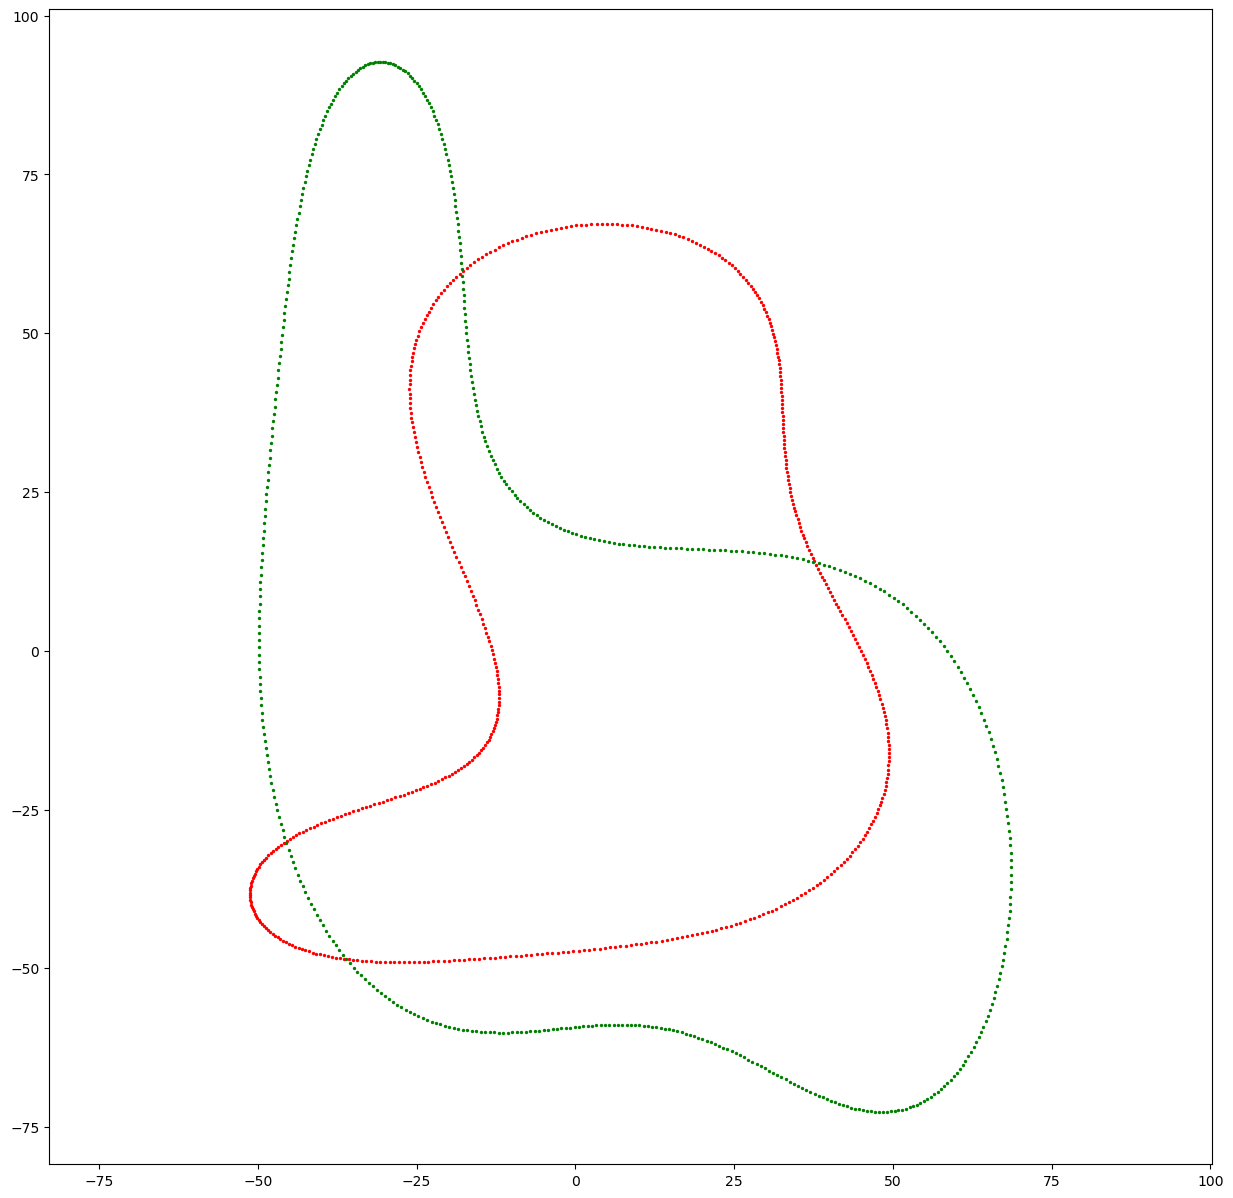

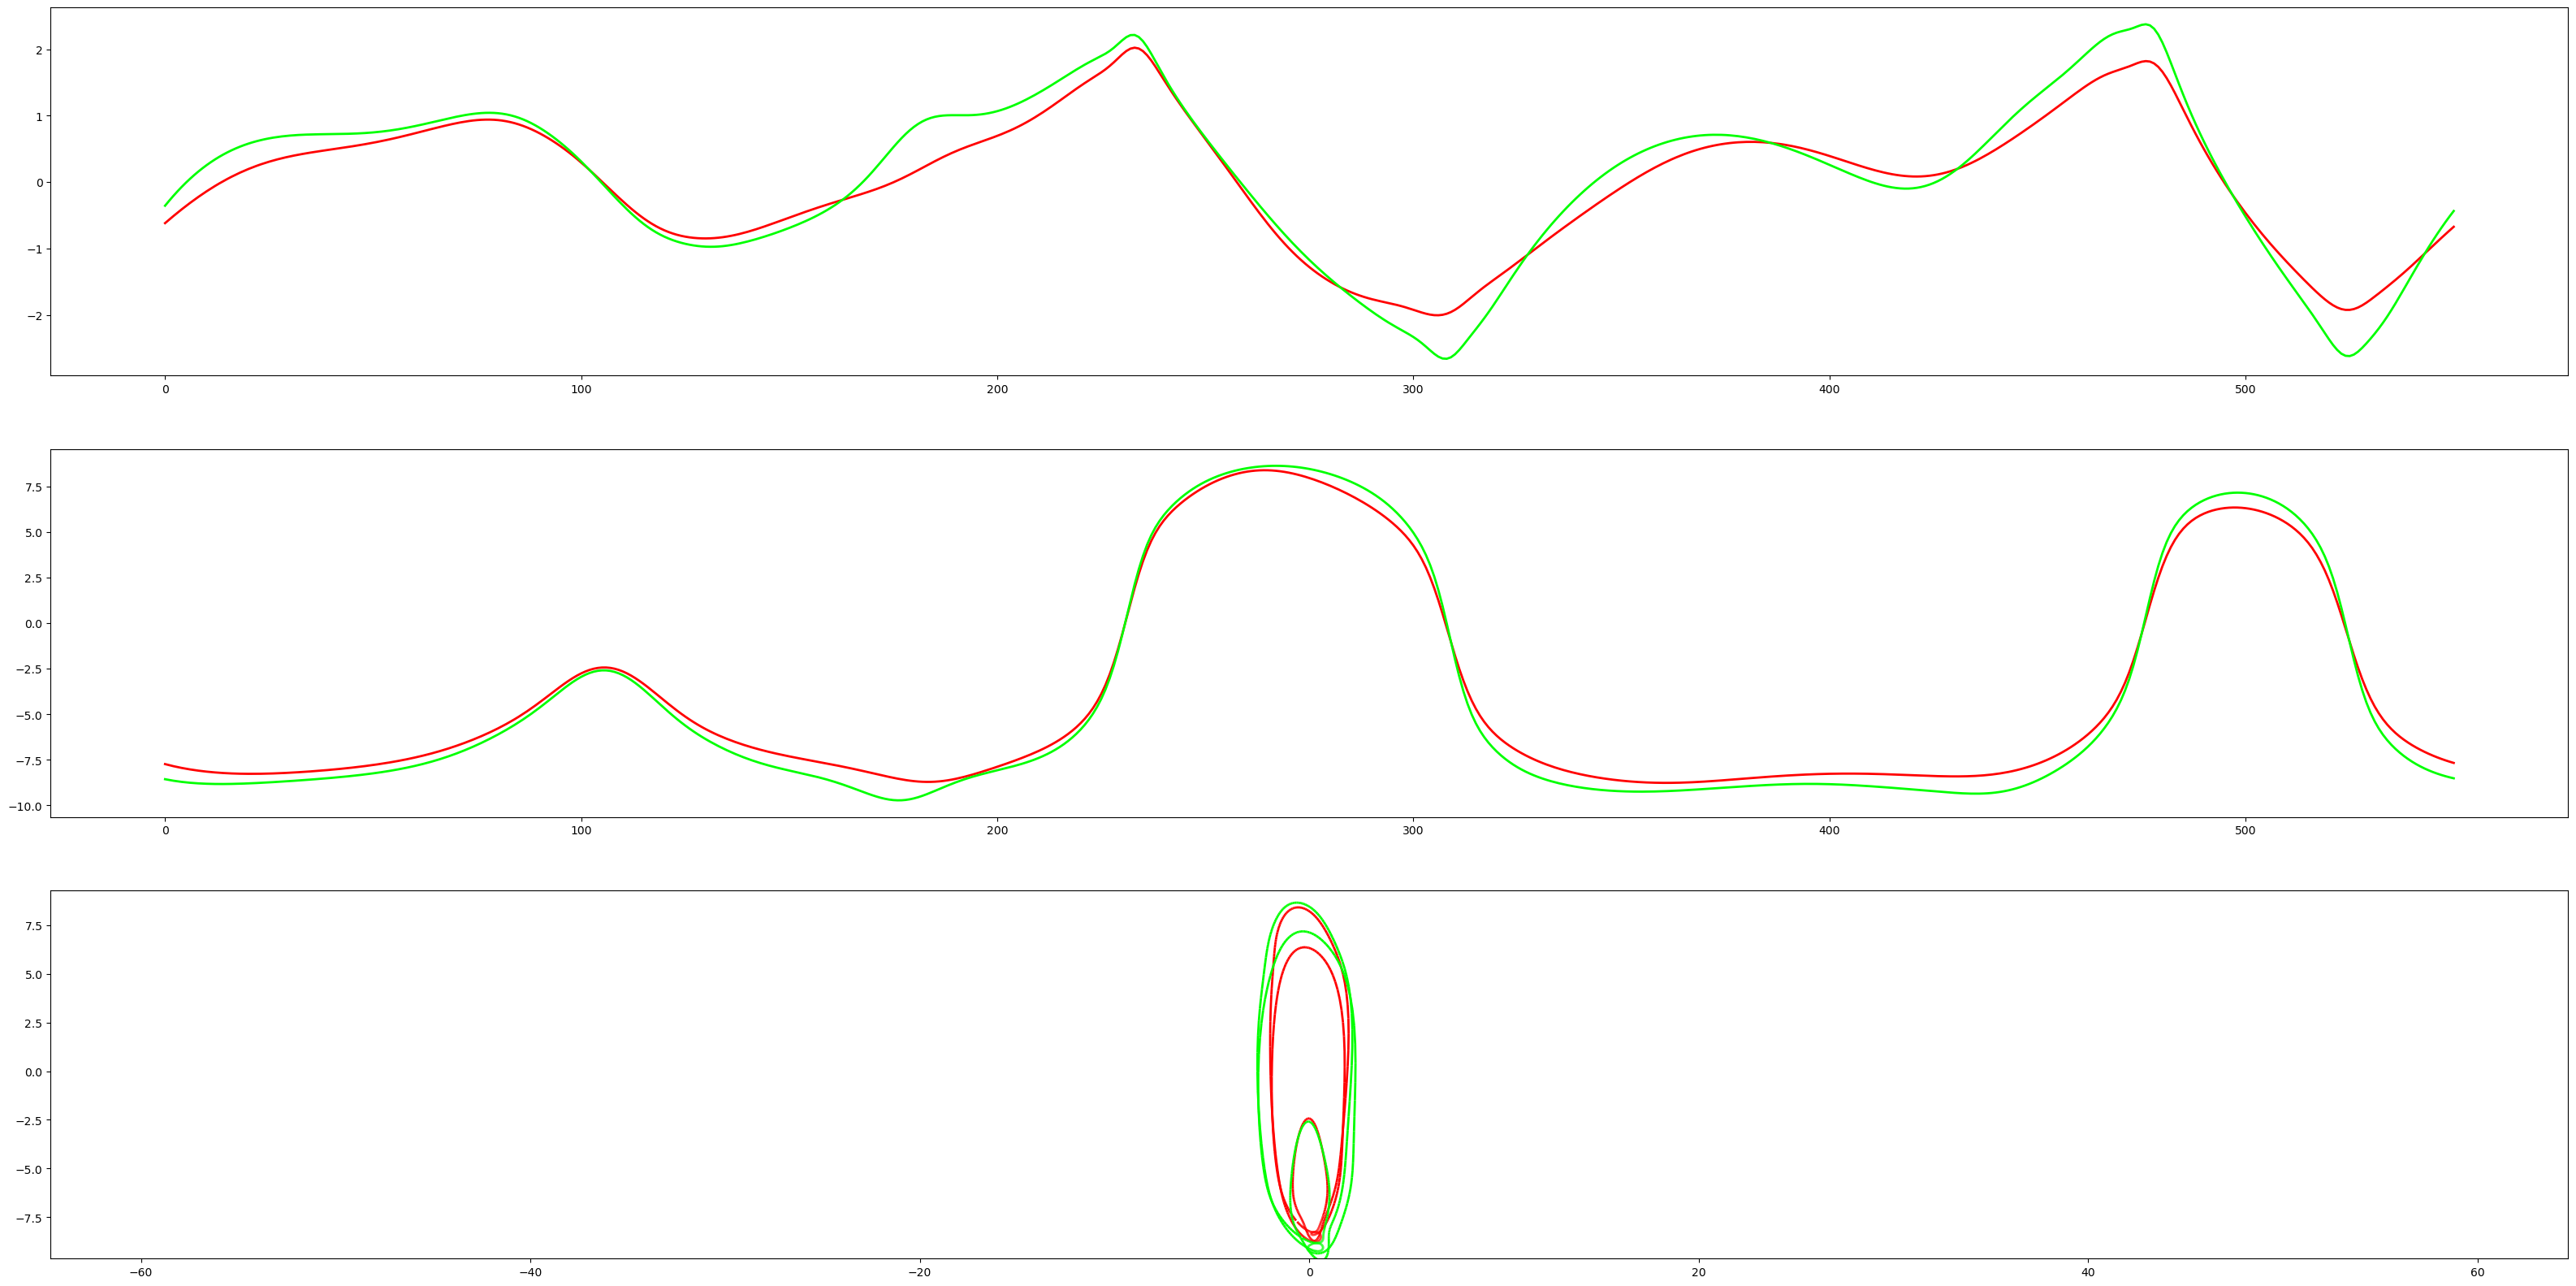

In [19]:
# def handle_curve_plot(curve: PlanarCurve):
#     discrete_distribution = discrete_distributions.MultimodalGaussianDiscreteDistribution(bins_count=curve.points_count, multimodality=10)
#     curve = curve.sample_curve(sampling_ratio=sampling_ratio, discrete_distribution=discrete_distribution)
#     # signature_curve = PlanarCurve(curve.approximate_curve_signature(model=model, supporting_points_count=supporting_points_count, device=device))
#
#     fig1, ax = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(15, 15))
#     curve.plot_scattered_curve(ax=ax)
#
#     curve_neighborhoods = curve.extract_curve_neighborhoods(supporting_points_count=supporting_points_count)
#     # for i in range(5):
#     curve_neighborhoods[0].plot_scattered_curve(ax=ax, cmap='green')
#     curve_neighborhoods[1].plot_scattered_curve(ax=ax, cmap='blue')
#     curve_neighborhoods[2].plot_scattered_curve(ax=ax, cmap='magenta')
#     curve_neighborhoods[3].plot_scattered_curve(ax=ax, cmap='orange')
#     curve_neighborhoods[4].plot_scattered_curve(ax=ax, cmap='cyan')
#
#     matplotlib.pyplot.show()
#
#
#     # fig2, axes = matplotlib.pyplot.subplots(nrows=3, ncols=1, figsize=(40, 20))
#     # signature_curve.plot_signature(model=model, supporting_points_count=supporting_points_count, device=device, ax=axes, line_style='-')
#     # matplotlib.pyplot.show()
#     # matplotlib.pyplot.close(fig1)
#     # matplotlib.pyplot.close(fig2)

def handle_curve_plot(curve: PlanarCurve):
    discrete_distribution = discrete_distributions.MultimodalGaussianDiscreteDistribution(bins_count=curve.points_count, multimodality=multimodality)
    curve = curve.sample_curve(sampling_ratio=sampling_ratio, discrete_distribution=discrete_distribution)
    signature_curve = PlanarCurve(curve.approximate_curve_signature(model=model, supporting_points_count=supporting_points_count, device=device))

    fig1, ax = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(15, 15))
    curve.plot_scattered_curve(ax=ax)

    fig2, axes = matplotlib.pyplot.subplots(nrows=3, ncols=1, figsize=(40, 20))
    signature_curve.plot_signature(model=model, supporting_points_count=supporting_points_count, device=device, ax=axes, line_style='-', force_limits=False)

    matplotlib.pyplot.show()

def handle_signature_comparison_plot(curve1: PlanarCurve, curve2: PlanarCurve):
    discrete_distribution1 = discrete_distributions.MultimodalGaussianDiscreteDistribution(bins_count=curve1.points_count, multimodality=multimodality)
    discrete_distribution2 = discrete_distributions.MultimodalGaussianDiscreteDistribution(bins_count=curve2.points_count, multimodality=multimodality)
    sampled_curve1 = curve1.sample_curve(sampling_ratio=sampling_ratio, discrete_distribution=discrete_distribution1)
    sampled_curve2 = curve2.sample_curve(sampling_ratio=sampling_ratio, discrete_distribution=discrete_distribution2)
    # signature_curve1 = PlanarCurve(sampled_curve1.approximate_curve_signature(model=model, supporting_points_count=supporting_points_count, device=device))
    # signature_curve2 = PlanarCurve(sampled_curve2.approximate_curve_signature(model=model, supporting_points_count=supporting_points_count, device=device))

    fig1, ax = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(15, 15))
    sampled_curve1.plot_scattered_curve(ax=ax, cmap=None, color='red')
    sampled_curve2.plot_scattered_curve(ax=ax, cmap=None, color='green')

    fig2, axes = matplotlib.pyplot.subplots(nrows=3, ncols=1, figsize=(40, 20))
    # signature_curve.plot_signature(model=model, supporting_points_count=supporting_points_count, device=device, ax=axes, line_style='-')
    sampled_curve1.plot_signature_comparison(comparison_curve=sampled_curve2, model=model, supporting_points_count=supporting_points_count, device=device, ax=axes, line_style='-', marker='')

    matplotlib.pyplot.show()


# circle = circles_new[0]
# handle_curve_plot(curve=circle)


# group = EquiaffineGroup(min_cond=2, max_cond=2, seed=43)
group = AffineGroup(min_cond=1.5, max_cond=1.5, min_det=1.5, max_det=1.5, seed=43)
for i in range(0, 1):
    curve1 = planar_curves_manager_smooth.planar_curves[6]
    # curve2 = planar_curves_manager_smooth.planar_curves[7]
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action())
    print(curve1.points.shape[0])
    print(curve2.points.shape[0])
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2)


# group = EquiaffineGroup(min_cond=2, max_cond=2, seed=43)
# group = AffineGroup(min_cond=2, max_cond=2, min_det=2, max_det=2, seed=43)
# for i in range(0, 1):
#     curve1 = benchmark_1_0.planar_curves[0]
#     curve2 = benchmark_0_8.planar_curves[0]
#     print(curve1.points.shape[0])
#     print(curve2.points.shape[0])
#     handle_signature_comparison_plot(curve1=curve1, curve2=curve2)

In [7]:
# comparator = PlanarCurvesApproximatedSignatureComparator(
#     model=model,
#     supporting_points_count=supporting_points_count,
#     device=device)
#
# shape_matching_evaluator = PlanarCurvesShapeMatchingEvaluator(
#     log_dir_path=Path("C:/deep-signature-data-new/notebooks_output"),
#     num_workers=18,
#     curves_count_per_collection=20,
#     curve_collections_file_names=['basketball', 'bats', 'birds', 'branches', 'bunnies', 'butterflies', 'cacti', 'cats', 'chickens', 'clouds', 'deers', 'dogs', 'fishes', 'flames', 'flies', 'fruits', 'glasses', 'hearts', 'horses', 'insects', 'jogging', 'leaves', 'monkies', 'pieces', 'shapes', 'whales', 'wings'],
#     benchmark_dir_path=Path('C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19'),
#     sampling_ratios=[0.7, 0.8, 0.9, 1.0],
#     multimodalities=[10],
#     group_names=['equiaffine'],
#     planar_curves_signature_comparator=comparator)
#
# # shape_matching_evaluator = PlanarCurvesShapeMatchingEvaluator(
# #     log_dir_path=Path("C:/deep-signature-data-new/notebooks_output"),
# #     num_workers=10,
# #     curves_count_per_collection=20,
# #     curve_collections_file_names=['basketball'],
# #     benchmark_dir_path=Path('C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19'),
# #     sampling_ratios=[0.6],
# #     multimodalities=[10],
# #     group_names=['equiaffine'],
# #     planar_curves_signature_comparator=comparator)
#
# shape_matching_evaluator.start()
# shape_matching_evaluator.join()
#
# print(shape_matching_evaluator.shape_matching_df)
# shape_matching_evaluator.shape_matching_df.to_csv("C:/deep-signature-data-new/notebooks_output/output.csv")